In [78]:
!pip install tqdm

In [79]:
from torchvision import models
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image 
from tqdm import tqdm

## Dataloading, Plots, Transforms

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])




trainset = torchvision.datasets.CIFAR10(root=r"/data",
                                         train=True,
                                         download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root=r"/data",
                                         train=False,
                                         download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

## Plotting the Images

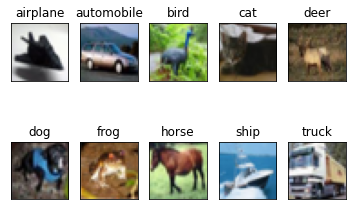

In [4]:
fig = plt.figure(1)
i=0
all_true =[False]*10
counter=0

indexes = []

for a in range(10):
    indexes.append(trainset.targets.index(a) )


for index in indexes:
    Nimg = index
    fig.add_subplot(2,5,i+1)
    i+=1
    plt.imshow(trainset.data[Nimg])
    plt.xticks([])
    plt.yticks([])
    plt.title(trainset.classes[trainset.targets[Nimg]])
    
 

## Pretrained Models (Resnet)

In [5]:
from torchvision import models
from torchvision import transforms

In [6]:
model = models.resnet18(pretrained = True)

In [173]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## B) Tricking the model to predict frog as whistle

In [54]:
from PIL import Image,ImageOps, ImageFilter
frog = Image.open("frog.jpg")
im2 = frog.filter(ImageFilter.GaussianBlur(15))

In [43]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
flip_frog = preprocess(im2)

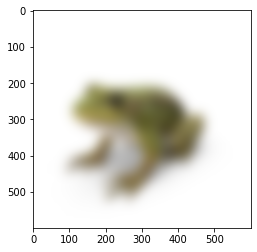

In [48]:
plt.imshow(im2)

/home/sgupta/.pyenv/versions/3.6.8/envs/rcnn/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


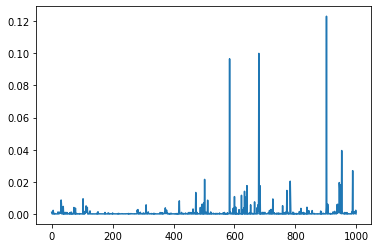

In [45]:
outputK = model(flip_frog.unsqueeze(0))
probs = torch.nn.Softmax()(outputK)
plt.plot(probs.detach().cpu()[0])

In [49]:
probs.argmax()

tensor(902)

In [50]:
import json

labels = json.load(open("classes.json",'r'))
def get_output_class(index):
    return labels[str(index)]



In [52]:
get_output_class(int(probs.argmax()))

['n04579432', 'whistle']

# Transfer learning 

In [83]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root=r"/data",
                                         train=True,
                                         download=True,
                                         transform = preprocess)

testset = torchvision.datasets.CIFAR10(root=r"/data",
                                         train=False,
                                         download=True,
                                         transform = preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128)
testloader = torch.utils.data.DataLoader(testset, batch_size = 128)

In [57]:
images, labels = next(iter(trainloader))

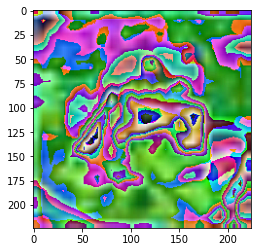

In [58]:
plt.imshow(transforms.ToPILImage()(images[0]))

In [59]:
output1layer = model.conv1(images[0].unsqueeze(0))

In [60]:
output1layer.shape

torch.Size([1, 64, 112, 112])

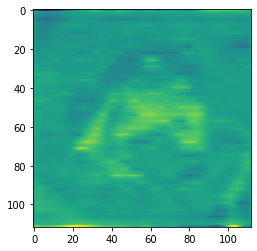

In [61]:
plt.imshow(output1layer[0, 10].detach())

In [104]:
# for chi in model.children():
#     if isinstance(chi, torch.nn.Sequential):
#         for chi2 in chi.children():
#             for chi3 in chi2.children():

                
            

In [62]:
for paramt in model.parameters():
    paramt.requires_grad= False

In [63]:
model.fc = torch.nn.Linear(512, 10)

In [64]:
loss_f = torch.nn.CrossEntropyLoss()

In [82]:
optimizer = torch.optim.SGD(model.parameters(),momentum=0.9 , lr=0.01)

In [93]:

class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [94]:
stopping = EarlyStopper(patience=3)

True

In [101]:
Nepochs = 10
validtion_acc = []
for i in range(Nepochs):
    model.train()
    train_loss = 0
    for j, batch in tqdm(enumerate(trainloader, 0), unit="batch", total=len(trainloader)):
        try:
            images, labes = batch
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_f(outputs, labes)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            # if j%100 == 0:
            #     print(loss.item())
        except Exception as e:
            pass
    
    valid_loss = 0
    model.eval()
    correct = 0
    for j, batch in tqdm(enumerate(testloader, 0), unit="batch", total=len(testloader)): 
        try:
            images, labes = batch
            outputs = model(images)
            loss = loss_f(outputs, labes)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labes).sum().item()
        except Exception as e:
            pass
    # print("acc: ",correct/len(testloader))
    validtion_acc.append(correct/len(testloader)) 
    print("Validation loss {}: ".format(i), valid_loss/len(testloader))

    if stopping.early_stop(validation_loss=valid_loss):
        break
    
    
    

 23%|██▎       | 88/391 [02:06<09:21,  1.85s/batch]

In [98]:
validtion_acc

[2.281566800950449, 2.284705669065065, 2.2871750608275208, 2.2891960113863403]

In [70]:
model.eval()
output = model(images)


In [76]:
outputK = model(flip_frog.unsqueeze(0))
probs = torch.nn.Softmax()(outputK)
trainset.classes[int(probs.argmax())]

/home/sgupta/.pyenv/versions/3.6.8/envs/rcnn/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


'automobile'

## 4) Transfer learning for first conv layers

In [ ]:
model = models.resnet18(pretrained = True)
for paramt in model.parameters():
    paramt.requires_grad= False

In [ ]:
chi = model.layer1.children()
chi = next(chi)

chi2 = chi.children()
chi2 = next(chi2)

print(chi2)
